# Continue a finished WorkGraph

## Introduction

`WorkGraph` supports adding new tasks to an already finished workgraph to continue the workflow. To do this, `WorkGraph` saves its data as an extra attribute of its process, so that one can rebuild the `WorkGraph` from the process.

In [1]:
%load_ext aiida
from aiida import load_profile

load_profile()

Profile<uuid='36f11577e5ee4adf9e4a5f5d62d3ae9b' name='presto'>

## Submit an `add_multiply` WorkGraph

We first create and submit a `WorkGraph` that adds two numbers and multiplies the sum by a factor.

In [2]:
from aiida_workgraph import task, WorkGraph


@task
def add(x, y):
    return x + y


@task
def multiply(x, y):
    return x * y


wg = WorkGraph("first_workflow")
wg.add_task(add, name="add1", x=2, y=3)
wg.add_task(multiply, name="multiply1", y=4)
wg.add_link(wg.tasks["add1"].outputs[0], wg.tasks["multiply1"].inputs["x"])

wg.submit(wait=True)

WorkGraph process created, PK: 8607
Process 8607 finished with state: FINISHED


<WorkGraphNode: uuid: fdae1482-2cda-488e-bbc1-71dbb21bc5ab (pk: 8607) (aiida.workflows:workgraph.engine)>

## Continue the WorkGraph with new tasks

To continue the workflow, we can load, restart, and extend the completed workgraph. We use the `load` method to load the `WorkGraph` by its `pk`, run `restart` to unseal the process, then add a second `add` task on top, linking the outputs of the previous workgraph as inputs.


In [3]:
pk = wg.pk
wg2 = WorkGraph.load(pk)
wg2.restart()
wg2.add_task(add, name="add2")
wg2.add_link(wg2.tasks["add1"].outputs[0], wg2.tasks["add2"].inputs["x"])
wg2.add_link(wg2.tasks["multiply1"].outputs[0], wg2.tasks["add2"].inputs["y"])
wg2.submit(wait=True)

Reset tasks: []
WorkGraph process created, PK: 8616
Process 8616 finished with state: FINISHED


<WorkGraphNode: uuid: 7b404ca0-7dac-44de-bc85-27fe07db8ea0 (pk: 8616) (aiida.workflows:workgraph.engine)>

### Check status and results


In [4]:
print(f"State of WorkGraph   : {wg2.state}")
print(f"Result of add1       : {wg.tasks.add1.outputs.result.value}")
print(f"Result of multiply1  : {wg.tasks.multiply1.outputs.result.value}")
print(f"Result of add2       : {wg2.tasks.add2.outputs.result.value}")

State of WorkGraph   : FINISHED
Result of add1       : uuid: d9b16859-01e6-4242-b9e3-34bbb3c24e2a (pk: 8611) value: 5
Result of multiply1  : uuid: e137ce7a-256c-43a3-a31a-d833472c281d (pk: 8615) value: 20
Result of add2       : uuid: aa3145dd-bd68-479c-9e49-eec114c50cbf (pk: 8620) value: 25


## The extended provenance

The full provenance remains intact, including the original workflow.

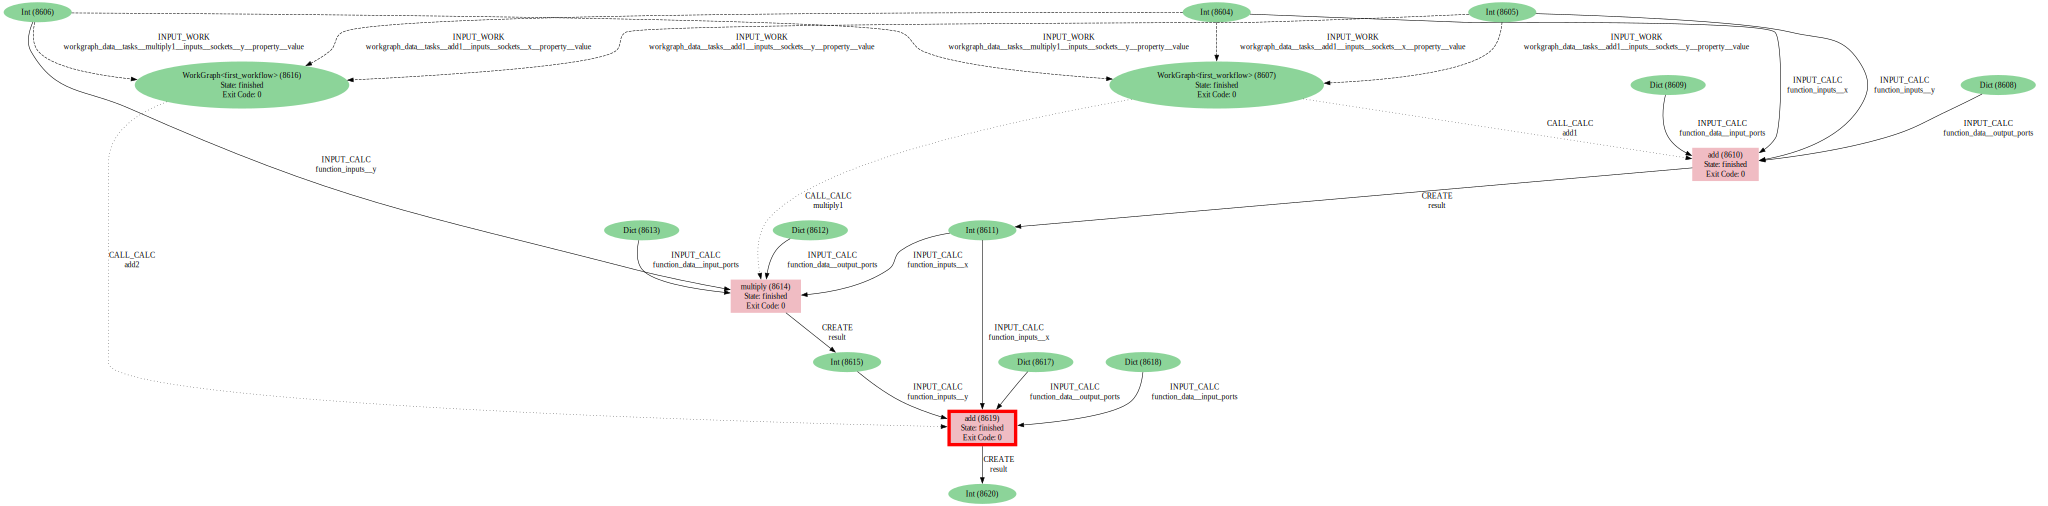

In [6]:
from aiida_workgraph.utils import generate_node_graph

generate_node_graph(wg2.tasks["add2"].pk)

## Summary

In this section, you learned how to continue a finished `WorkGraph` by adding new tasks to a loaded, completed workgraph. This allows you to extend workflows without losing the original provenance, enabling a flexible and iterative approach to workflow management in AiiDA.